In [2]:
import torch
import torch.nn as nn
import torch.optim
import torchvision
import torchvision.transforms.v2 as v2
import torchvision.datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import random

from tqdm import tqdm

In [3]:
transform = v2.Compose([
    v2.Resize([64,64]),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

train_data = torchvision.datasets.Flowers102("dataset/flowers102", split="train", transform=transform, download=True)
test_data = torchvision.datasets.Flowers102("dataset/flowers102", split="test", transform=transform, download=True)

torch.Size([3, 64, 64])
tensor([0.0627, 0.0588, 0.0667, 0.0627, 0.1412])


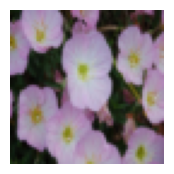

In [4]:
print(train_data[0][0].shape)
print(train_data[0][0][0,0,:5])
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(train_data[0][0].permute(1,2,0))
plt.show()

tensor([0.0001, 0.0002, 0.0004, 0.0005, 0.0007])
tensor([0.9999, 0.9998, 0.9996, 0.9995, 0.9993])


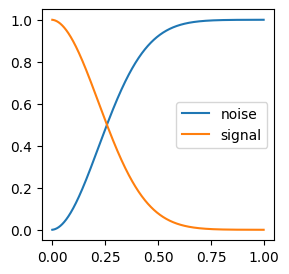

In [5]:
def linear_diffusion_schedule(diffusion_times):
    min_rate = 0.0001
    max_rate = 0.02
    betas = min_rate + torch.tensor(diffusion_times) * (max_rate - min_rate)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim = 0)
    signal_rates = alpha_bars
    noise_rates = 1 - alpha_bars
    return noise_rates, signal_rates

T = 1000
diffusion_times = [x/T for x in range(T)]
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(diffusion_times)
print(linear_noise_rates[:5])
print(linear_signal_rates[:5])
plt.figure(figsize=(3,3))
plt.plot(diffusion_times, linear_noise_rates, label="noise")
plt.plot(diffusion_times, linear_signal_rates, label="signal")
plt.legend()
plt.show()

In [6]:
def cosine_diffusion_schedule(diffusion_times):
    signal_rates = torch.cos(diffusion_times * torch.pi / 2)
    noise_rates = torch.sin(diffusion_times * torch.pi / 2)
    return noise_rates, signal_rates

def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = torch.tensor(0.02)
    max_signal_rate = torch.tensor(0.95) 
    start_angle = torch.acos(max_signal_rate)
    end_angle = torch.acos(min_signal_rate)
    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
    signal_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)

    return noise_rates, signal_rates

T = 1000
diffusion_times = [x/T for x in range(T)]
diffusion_times = torch.tensor(diffusion_times, dtype=torch.float32)

cos_noise_rates, cos_signal_rates = cosine_diffusion_schedule(diffusion_times)
off_cos_noise_rates, off_cos_signal_rates = offset_cosine_diffusion_schedule(diffusion_times)

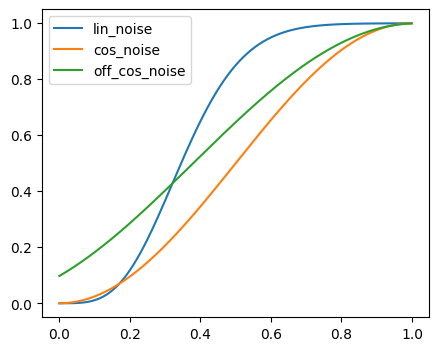

In [7]:
plt.figure(figsize=(5,4))
plt.plot(diffusion_times, linear_noise_rates**2, label="lin_noise")
plt.plot(diffusion_times, cos_noise_rates**2, label="cos_noise")
plt.plot(diffusion_times, off_cos_noise_rates**2, label="off_cos_noise")
plt.legend()
plt.show()

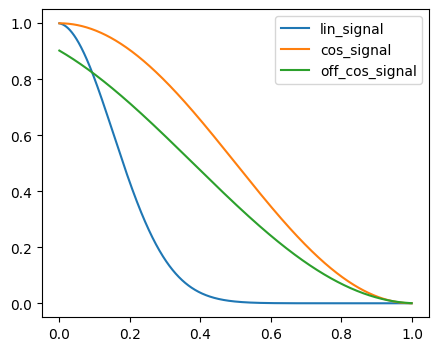

In [8]:
plt.figure(figsize=(5,4))
plt.plot(diffusion_times, linear_signal_rates**2, label="lin_signal")
plt.plot(diffusion_times, cos_signal_rates**2, label="cos_signal")
plt.plot(diffusion_times, off_cos_signal_rates**2, label="off_cos_signal")
plt.legend()
plt.show()

In [46]:
import math

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        emb = emb.reshape(emb.shape[0], -1, 1, 1)
        return emb

model = SinusoidalPosEmb(dim=32)
sample = torch.tensor(0.34, dtype=torch.float32)
sample = sample.reshape([1,1,1])
sample = sample.repeat(3,1,1,1)
print(sample)
print(sample.shape)
res = model(sample)
print(res[0,:3,])
print(res[1,:3,])
print("SinusoidalPosEmb", res.shape)

tensor([[[[0.3400]]],


        [[[0.3400]]],


        [[[0.3400]]]])
torch.Size([3, 1, 1, 1])
tensor([[[0.3335]],

        [[0.1830]],

        [[0.0994]]])
tensor([[[0.3335]],

        [[0.1830]],

        [[0.0994]]])
SinusoidalPosEmb torch.Size([3, 32, 1, 1])


In [47]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel, out_channels, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.in_channel = in_channel
        self.out_channel = out_channels
        self.conv_input = nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.swish = nn.SiLU()

    def forward(self, x):
        input_width = x.shape[1]
        if input_width == self.out_channel:
            residual = x
        else:
            residual = self.conv_input(x)
        
        x = self.conv1(x)
        x = self.swish(x)
        x = self.conv2(x)
        x = torch.add(x, residual)

        return x

model = ResidualBlock(3, 64)
sample = torch.randn([1,3,64,64])
res = model(sample)
print("ResidualBlock", res.shape)

ResidualBlock torch.Size([1, 64, 64, 64])


In [48]:

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.res1 = ResidualBlock(in_channel=self.in_channels, out_channels=self.out_channels)
        self.res2 = ResidualBlock(in_channel=self.out_channels, out_channels=self.out_channels)

        self.avg_pool = nn.AvgPool2d(kernel_size=2)
    
    def forward(self, x):
        res_out_1 = self.res1(x)
        res_out_2 = self.res2(res_out_1)
        out = self.avg_pool(res_out_2)

        return out, res_out_1, res_out_2

model = DownBlock(in_channels=64, out_channels=32)
sample = torch.randn([1,64,64,64])
out, skip1, skip2 = model(sample)
print(out.shape)
print(skip1.shape)
print(skip2.shape)

torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 64, 64])
torch.Size([1, 32, 64, 64])


In [49]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.skip_channels = skip_channels

        self.up_sample = nn.UpsamplingBilinear2d(scale_factor=2)
        self.res1 = ResidualBlock(in_channel=self.in_channels + skip_channels, out_channels=out_channels)
        self.res2 = ResidualBlock(in_channel=self.out_channels + skip_channels, out_channels=out_channels)

    def forward(self, x, skip1, skip2):
        out = self.up_sample(x)
        out = torch.cat([out, skip2], dim=1)
        out = self.res1(out)
        out = torch.cat([out, skip1], dim=1)
        out = self.res2(out)
        return out

model = UpBlock(in_channels=128, out_channels=96, skip_channels=96)
skip1 = torch.randn([1,96,16,16])
skip2 = torch.randn([1,96,16,16])
sample = torch.randn([1,128,8,8])

out = model(sample, skip1, skip2)
print("UpBlock", out.shape)


UpBlock torch.Size([1, 96, 16, 16])


In [54]:
class UNet(nn.Module):
    def __init__(self, emb_dim, input_size, in_channel, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.emb_dim = emb_dim
        self.input_size = input_size
        self.in_channel = in_channel
        
        self.sinusodialPosEmb = SinusoidalPosEmb(self.emb_dim)
        self.upsample = nn.UpsamplingNearest2d(size=self.input_size)

        self.conv_in = nn.Conv2d(in_channels=in_channel, out_channels=emb_dim, kernel_size=3, padding=1)

        self.down_block1 = DownBlock(in_channels=emb_dim*2, out_channels=emb_dim)
        self.down_block2 = DownBlock(in_channels=emb_dim, out_channels=emb_dim*2)
        self.down_block3 = DownBlock(in_channels=emb_dim*2, out_channels=emb_dim*3)
        
        self.res_1 = ResidualBlock(in_channel=emb_dim*3, out_channels=emb_dim*4)
        self.res_2 = ResidualBlock(in_channel=emb_dim*4, out_channels=emb_dim*4)

        self.up_block1 = UpBlock(in_channels=emb_dim*4, out_channels=emb_dim*3, skip_channels=emb_dim*3)
        self.up_block2 = UpBlock(in_channels=emb_dim*3, out_channels=emb_dim*2, skip_channels=emb_dim*2)
        self.up_block3 = UpBlock(in_channels=emb_dim*2, out_channels=emb_dim, skip_channels=emb_dim)

        self.conv_out = nn.Conv2d(in_channels=emb_dim, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x_t, noise_variance):
        noise_emb = self.sinusodialPosEmb(noise_variance)
        noise_emb = self.upsample(noise_emb)
        xt_emb = self.conv_in(x_t)
        emb = torch.cat([noise_emb, xt_emb], dim=1)
        out, db1_skip1, db1_skip2 = self.down_block1(emb)
        out, db2_skip1, db2_skip2 = self.down_block2(out)
        out, db3_skip1, db3_skip2 = self.down_block3(out)

        out = self.res_1(out)
        out = self.res_2(out)

        out = self.up_block1(out, db3_skip1, db3_skip2)
        out = self.up_block2(out, db2_skip1, db2_skip2)
        out = self.up_block3(out, db1_skip1, db1_skip2)

        out = self.conv_out(out)
        return out
    
model = UNet(emb_dim=32, input_size=64, in_channel=3)
xt_sample = torch.randn([5,3,64,64])
noise_sample = torch.tensor(0.34, dtype=torch.float32)
noise_sample = noise_sample.reshape([1,1,1])
noise_sample = noise_sample.repeat(5,1,1,1)
out = model(xt_sample, noise_sample)
print(out.shape)

torch.Size([5, 3, 64, 64])


In [10]:
class DiffusionTrainer():
    def __init__(self) -> None:
        
        self.normalizer = v2.Normalize(
            mean=[0.485, 0.456, 0.406]
            ,std=[0.229, 0.224, 0.225]
            )
        self.diffusion_schdule = offset_cosine_diffusion_schedule

    def train_step(self, images):
        images = self.normalizer(images)
        noises = torch.randn_like(images)
        batch_size = images.shape[0]
        diffusion_times = torch.rand(size=[batch_size, 1, 1, 1])
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # x_t = \sqrt{\bar{\alpha}_t} + \sqrt{1 - \bar{\alpha}_t} noise
        noisy_images = signal_rates * images + noise_rates * noises
        
        
        